# KMV Model for Air Canada

## Parameter Calculation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

price_df = pd.read_csv('./AC-price.csv')
price_df["Date"] = pd.to_datetime(price_df["Date"])
price_df.rename(columns={"AC.TO": "Price"}, inplace=True)

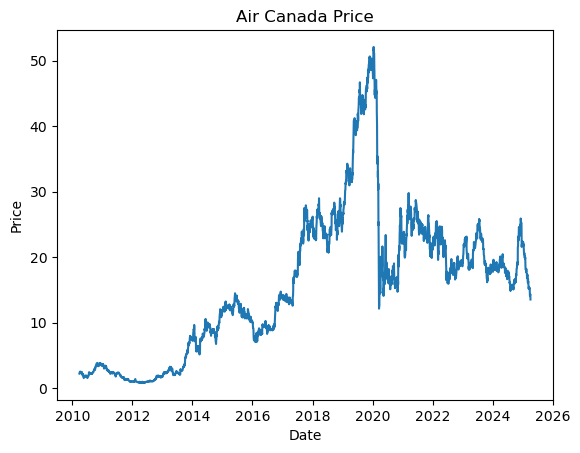

In [2]:
plt.figure()
plt.plot(price_df["Date"], price_df["Price"])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Air Canada Price")
plt.show()

In [3]:
# stock volatility (daily)
sigma_S = price_df["Price"].to_numpy()
sigma_S = np.std(np.log(sigma_S[1:] / sigma_S[:-1])) * np.sqrt(252)

# Asset
V = 31208000

# Liability
L = 28820000

# risk free rate
r_df = pd.read_csv("./risk-free-rate.csv")

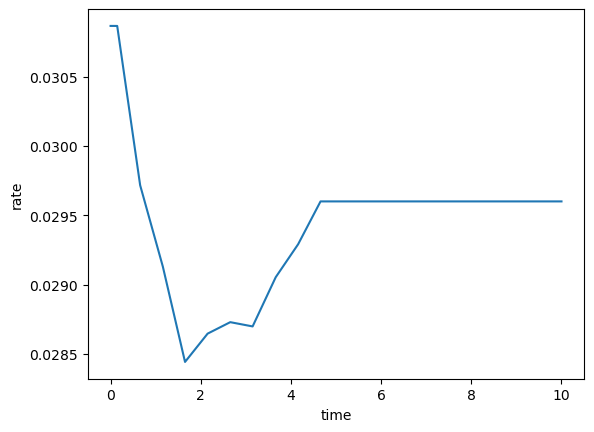

In [4]:
plt.figure()
plt.plot(r_df["dt"], r_df["r"])
plt.xlabel("time")
plt.ylabel("rate")
# plt.title("Yield Curve")
plt.show()

## Default Probability Calculation

In [5]:
from scipy.stats import norm


def BS_delta(S, K, T, r, sigma):
    """
    Calculate Black-Scholes Delta for European Call option.

    Parameters:
        S : float : Spot price of the underlying asset
        K : float : Strike price
        T : float : Time to maturity (in years)
        r : float : Risk-free interest rate (annualized, decimal form)
        sigma : float : Volatility of the underlying asset (annualized, decimal form)

    Returns:
        Delta : float : Option Delta
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)


def BS_Price(S, K, T, r, sigma):
    """
    Calculate Black-Scholes price of a European Call Option.

    Parameters:
        S : float : Spot price of the underlying asset
        K : float : Strike price
        T : float : Time to maturity (in years)
        r : float : Risk-free interest rate (annualized, decimal form)
        sigma : float : Volatility of the underlying asset (annualized, decimal form)

    Returns:
        call_price : float : Price of the call option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    return call_price


def P_default(S, K, T, r, sigma):
    """
    Calculate the Default probability at expiry T.

    Parameters:
        S : float : Spot price of the underlying asset
        K : float : Strike price
        T : float : Time to maturity (in years)
        r : float : Risk-free interest rate (annualized, decimal form)
        sigma : float : Volatility of the underlying asset (annualized, decimal form)

    Returns:
        call_price : float : Price of the call option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return norm.cdf(-d2)

compute asset volatility

In [6]:
def asset_vol(T: float, r: float, verbose = False):
    error = np.inf
    sigma_A = sigma_S * np.sqrt(T * 252)
    
    iteration = 0
    while error > 1e-5:
        sigma_A_update = sigma_S * BS_Price(V, L, T, r, sigma_A) / (V * BS_delta(V, L, T, r, sigma_A))
        error = np.abs(sigma_A_update - sigma_A)
        if verbose:
            print(f"Iteration {iteration}: sigma_A {round(sigma_A, 4)}, new sigma_A {round(sigma_A_update, 4)}")
        sigma_A = sigma_A_update
        iteration += 1
    return float(sigma_A)

compute probability of default

In [115]:
NT = len(r_df)
P_dft = np.zeros(NT)
for i in trange(NT):
    # calculate asset volatility
    r = r_df["r"].iloc[i]
    T = r_df["dt"].iloc[i]
    sigma_A = asset_vol(T, r)
    P_dft[i] = P_default(V, L, T, r, sigma_A)

100%|██████████| 10000/10000 [01:04<00:00, 156.19it/s]


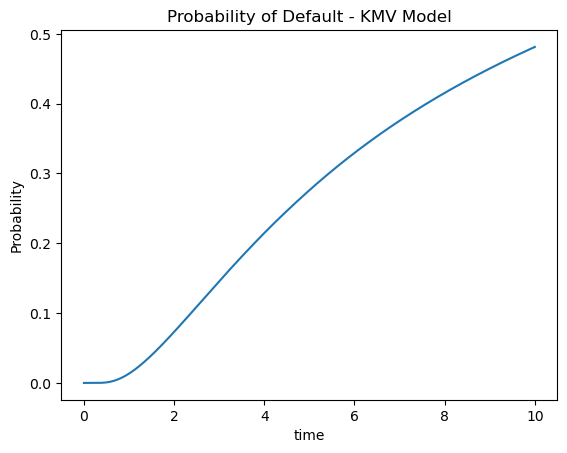

In [116]:
plt.figure()
plt.plot(r_df["dt"], P_dft)
plt.xlabel("time")
plt.ylabel("Probability")
plt.title("Probability of Default - KMV Model")
plt.show()

In [117]:
pd.DataFrame({"dt": r_df["dt"], "P_default": P_dft}).to_csv("./KMV-default-prob.csv", index=False)

In [119]:
print(f"Year {float(r_df['dt'].iloc[999])}, P(default) = {round(P_dft[999] * 100, 2)}%")

Year 1.0, P(default) = 1.34%


In [121]:
asset_vol(r_df["dt"][999], r_df["r"][999]) # one-year asset volatility

0.048624486610914994

The 1-year default probability: 1.34%.